In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/MADE/AdvML/hw_2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MADE/AdvML/hw_2


In [2]:
import pickle 
from datetime import datetime
from dateutil.tz import tzoffset


import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch import optim
from scipy.stats import kendalltau, spearmanr
from sklearn.preprocessing import OneHotEncoder

## Загрузка данных

In [3]:
with open("./data/players.pkl", "rb") as fio:
    players = pickle.load(fio)

with open("./data/results.pkl", "rb") as fio:
    results = pickle.load(fio)
    
with open("./data/tournaments.pkl", "rb") as fio:
    tournaments = pickle.load(fio)
    
dateformat = "%Y-%m-%dT%H:%M:%S%z"

In [4]:
train =  []
test = []

for key, value in results.items():
    for team in value:
        for team_member in team["teamMembers"]:
            tournament_year = datetime.strptime(tournaments[key]["dateStart"], dateformat).year
            if team.get("mask", None) and tournament_year == 2019:
                train.append({
                    "tournament_id": key,
                    "tournament_name": tournaments.get(key).get("name"),
                    "team_id": team["team"]["id"],
                    "team_name": team["team"]["name"],
                    "questions_mask": team.get("mask", None),
                    "questionQty": tournaments.get(key).get("questionQty"),
                    "position": team.get("position", None),
                    "player_id": team_member["player"]["id"],
                    "player_name": team_member["player"]["surname"] + " " + \
                                   team_member["player"]["name"] + " " + \
                                   team_member["player"]["patronymic"]
                })
            elif team.get("mask", None) and tournament_year == 2020:
                test.append({
                    "tournament_id": key,
                    "tournament_name": tournaments.get(key).get("name"),
                    "team_id": team["team"]["id"],
                    "team_name": team["team"]["name"],
                    "position": team.get("position", None),
                    "player_id": team_member["player"]["id"],
                    "player_name": team_member["player"]["surname"] + " " + \
                                   team_member["player"]["name"] + " " + \
                                   team_member["player"]["patronymic"]
                })

In [5]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [6]:
del results

### Предобработка

Отсеем команды, у которых количество ответов отличается от количества вопросов

In [7]:
train["questionQty"] = train["questionQty"].apply(lambda x: sum(list(x.values())))
train = train[train["questions_mask"].apply(len) == train["questionQty"]].copy()

Распределение игроков по командам выглядит так

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


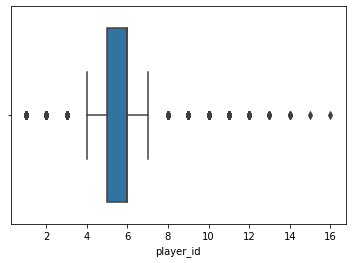

In [8]:
sns.boxplot(train.groupby(["team_id", "tournament_id"])["player_id"].nunique())

Максимальный размер команды в ЧГК - 6 человек. Большая часть распределения лежит в промежутке от 4 до 7. Вполне вероятно, что в течение сезона игроки менялись, но новые игроки в рейтинге числятся как "легионеры". Это объясняет команды с числом игроков больше 10

## Задача 2 
Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:

- повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
- в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
- для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


In [9]:
qa_data = {
    "question": [],
    "player": [],
    "initial_label": [],
    "team_id": [],
    "tournament_id": []
}

for tour_id, team_id, player_id, mask in zip(train["tournament_id"], train["team_id"], train["player_id"], train["questions_mask"]):
    for i, result in enumerate(mask):
        if result != "X" and result != "?":
            qa_data["tournament_id"].append(tour_id)
            qa_data["team_id"].append(team_id)
            qa_data["question"].append(f"{tour_id}_{i}")
            qa_data["player"].append(player_id)
            qa_data["initial_label"].append(int(result))

qa_data = pd.DataFrame(qa_data)

In [10]:
qa_data

,question,player,initial_label,team_id,tournament_id
0,4772_0,6212,1,45556,4772
1,4772_1,6212,1,45556,4772
2,4772_2,6212,1,45556,4772
3,4772_3,6212,1,45556,4772
4,4772_4,6212,1,45556,4772
...,...,...,...,...,...
17739653,6255_211,210786,0,60897,6255
17739654,6255_212,210786,0,60897,6255
17739655,6255_213,210786,0,60897,6255
17739656,6255_214,210786,0,60897,6255


In [11]:
encoder = OneHotEncoder()
train = encoder.fit_transform(qa_data[["player", "question"]])

In [12]:
class LogisticRegression(nn.Module):

    def __init__(self, n_features):  
        super().__init__()
        self.fc = nn.Linear(n_features, 1)
        self.sigmoid = nn.Sigmoid()     
  
    def forward(self, x):
        return self.sigmoid(self.fc(x))

In [13]:
def m_step(model, x, y, lr=1, n_iter=250):
    model.fc.reset_parameters()
    loss_func = nn.BCELoss()
    opt = optim.Adam(model.parameters(), lr)
    for i in range(n_iter):
        opt.zero_grad()
        output = model(x)
        loss = loss_func(output, y)
        loss.backward()
        opt.step()

In [14]:
def get_top_players(parameters, n=15):
    player_weights = {}
    for i, c in enumerate(encoder.get_feature_names()):
        if c.startswith("x0_"):
            player_weights[int(c[3:])] = parameters[i]
    top_players = sorted([(k, v) for k, v in player_weights.items()], reverse=True, key=lambda x: x[1])[:n]
    top_players = [" ".join([players[i]["surname"], players[i]["name"],players[i]["patronymic"]]) for i, e in top_players]
    return pd.DataFrame(top_players)

In [15]:
train = train.tocoo()

X_train = torch.sparse.FloatTensor(
    torch.LongTensor(np.vstack((train.row, train.col))),
    torch.FloatTensor(train.data)
)

y_train = torch.FloatTensor(qa_data["initial_label"].values).view(-1, 1)

model = LogisticRegression(X_train.shape[1])

In [16]:
m_step(model, X_train, y_train)

## Задача 3


Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:

 - предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
 - в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.

In [17]:
def calc_metrics(data, encoder, parameters, intercept):
    player_weights = {}
    count = 0
    question_sum = 0
    player_sum = 0
    player_cnt = 0
    for i, c in enumerate(encoder.get_feature_names()):
        if c.startswith("x0_"):
            player_weights[int(c[3:])] = parameters[i]
            player_sum += parameters[i]
            player_cnt += 1
        else:
            question_sum += parameters[i]
            count += 1
    question_mean = question_sum / count
    data["player_weights"] = data["player_id"].map(player_weights)
    data["player_weights"].fillna(player_sum / player_cnt, inplace=True)
    data["players_proba"] = data["player_weights"].apply(lambda x: 1 / (1 + np.exp(-(x + question_mean + intercept))))
    probas = data.groupby(["tournament_id", "team_id"])["players_proba"].apply(lambda x: np.prod(1 - x))
    position = data.groupby(["tournament_id", "team_id"])["position"].first()
    group_data = pd.concat([probas, position], axis=1)
    group_data.sort_values(["tournament_id", "players_proba"], ascending=[True, True], inplace=True)
    spearman = group_data.groupby("tournament_id").apply(lambda x: spearmanr(x["position"], x["players_proba"]).correlation).mean()
    kendall = group_data.groupby("tournament_id").apply(lambda x: kendalltau(x["position"], x["players_proba"]).correlation).mean()
    print(f"Spearman: {spearman}")
    print(f"Kendall: {kendall}")

In [18]:
calc_metrics(test, encoder, model.fc.weight.data[0].numpy(), model.fc.bias.data[0].numpy())

Spearman: 0.7860757084656506
Kendall: 0.6292054758858873


In [19]:
get_top_players(model.fc.weight.data[0].numpy())

,0
0,Руссо Максим Михайлович
1,Брутер Александра Владимировна
2,Семушин Иван Николаевич
3,Савченков Михаил Владимирович
4,Кудинов Дмитрий Сергеевич
5,Спешков Сергей Леонидович
6,Сорожкин Артём Сергеевич
7,Пилипенко Максим Игоревич
8,Мереминский Станислав Григорьевич
9,Подюкова Валентина


## Задача 4

Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:

 - предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
 - разработайте EM-схему для обучения этой модели, реализуйте её в коде;
 - обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.

In [20]:
def e_step(data, predicts):
    data["label"] = predicts
    data.loc[data["initial_label"] == 0, "label"] = 0
    idx = data["initial_label"] == 1
    sp = data.loc[idx].groupby(["team_id", "question"])["label"].transform(lambda x: 1 - np.prod(1 - x.values))
    data.loc[idx, "label"] = data.loc[idx, "label"] / sp  
    return data

In [24]:
predicts = model(X_train).detach().numpy().ravel()
for i in range(5):
    qa_data = e_step(qa_data, predicts)
    y = torch.FloatTensor(qa_data["label"].values).view(-1, 1)
    m_step(model, X_train, y)
    torch.save(model.state_dict(), f"model_{i}.pth")
    predicts = model(X_train).detach().numpy().ravel()
    print(f"Iter: {i}")
    calc_metrics(test, encoder, model.fc.weight.data[0].numpy(), model.fc.bias.data[0].numpy())

Iter: 0
Spearman: 0.7935780794473756
Kendall: 0.6378960016064524
Iter: 1
Spearman: 0.7959441346934494
Kendall: 0.6400254332134376
Iter: 2
Spearman: 0.7961825279132537
Kendall: 0.6402570660266335
Iter: 3
Spearman: 0.7987798869376065
Kendall: 0.6432918107415578
Iter: 4
Spearman: 0.8001365307267226
Kendall: 0.645031547762338


## Задача 5

А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

In [25]:
parameters = model.fc.weight.data[0].numpy()

question_weights = {}
for i, c in enumerate(encoder.get_feature_names()):
    if c.startswith("x1_"):
        question_weights[c[3:]] = parameters[i]

In [27]:
weights = qa_data.groupby("tournament_id")["question"].apply(lambda x: np.mean([question_weights[q] for q in x])).sort_values()
questions = weights.reset_index()["tournament_id"].apply(lambda x: tournaments[x]["name"])
questions.head()

0    Чемпионат Санкт-Петербурга. Первая лига
1                     Чемпионат Таджикистана
2     Зеркало мемориала памяти Михаила Басса
3                                Угрюмый Ёрш
4                         Воображаемый музей
Name: tournament_id, dtype: object